# 0. Import

In [3]:
##Import packages

import subprocess
import numpy as np
import os, sys, shutil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import pandas as pd
import gc
import math
import time

from sklearn.cluster import KMeans

%matplotlib notebook

# 1. Basic Funcs

## Find distance and pairs (Periodic Box)

In [4]:
def gaussian(x,mu,sig):
    return np.exp(-((x-mu)**2)/(2*sig**2))

In [5]:
# 0. Import## Identify all water molecules
def distance(box, atom, aim_pool):
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    return distance
def findNearest(box, atom, aim_pool, num):
    """
    Find the nearest one to given atom from a group of candidate
    Input: 
        box: periodic box size
        atom: given atom (position, dimention=3d)
        aim pool: a list of positions.
    Return:
        index of closest atom in aim_pool
    
    """
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    sorted_dis = sorted(distance)
    res = np.where(distance <= sorted_dis[num])[0]
    if len(res)>num:
        res = np.concatenate((np.where(distance < sorted_dis[num])[0],np.where(distance == sorted_dis[num])[0]))
        res = res[:num]
    return res

# 2. Hydrogen Bond Funcs

## Find Covalence Bonds and Bond Angles (Water molecules)

In [6]:
def get_O_in_OH(atoms_lines, box, eles):
    
    pos = [[float(_e) for _e in e.split()] for e in atoms_lines[1:]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)
    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]
    
    Os = atoms[np.where(atoms[:,0]=='O')[0],1:]
    Hs = atoms[np.where(atoms[:,0]=='H')[0],1:]

    dis_mat = np.zeros((len(Hs), len(Os)))
    for i in range(len(Hs)):
        dis_mat[i] = distance(box, Hs[i], Os)
    dis = np.array([np.where(e == min(e))[0][0] for e in dis_mat])
    return dis

In [7]:
def _if_bond_(lines, Os, Hs, box):
    
    OH_cutoff = 1.28
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    for i in range(len(box)):
        pos[:,i] = pos[:,i]*box[i]
    
    i = 0
    l = []
    ang = []
    
    
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec

    def __angle(vec1, vec2):
        a = vec1/np.linalg.norm(vec1)
        b = vec2/np.linalg.norm(vec2)
        temp = np.dot(vec1, vec2)
        if temp>1:
            temp=1
        if temp<-1:
            temp=-1
        return math.acos(temp)
    
    while i < len(Os):
        _O = Os[i]
        _num = np.count_nonzero(Os == _O, axis=0)
        vec = []
        for j in range(_num):
            _i = i+j 
            _temp = np.linalg.norm(__periodic(pos[Hs[_i]]-pos[Os[_i]],box))
            if _temp <= OH_cutoff:
                l.append(1)
                vec.append(1)
            else:
                l.append(0)
                vec.append(0)
        if _num > 1:
            temp = np.zeros((_num,_num))
            for _i in range(_num):
                for _j in range(_i+1,_num):
                    ang.append(vec[_i]*vec[_j])
        i=i+_num
    return np.array(l), np.array(ang)
                    
        

In [8]:
def bond_angle(lines, Os, Hs, box):
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    for i in range(len(box)):
        pos[:,i] = pos[:,i]*box[i]
    
    i = 0
    l = []
    ang = []
    
    
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec

    def __angle(vec1, vec2):
        a = vec1/np.linalg.norm(vec1)
        b = vec2/np.linalg.norm(vec2)
        temp = np.dot(vec1, vec2)
        if temp>1:
            temp=1
        if temp<-1:
            temp=-1
        return math.acos(temp)
    
    while i < len(Os):
        _O = Os[i]
        _num = np.count_nonzero(Os == _O, axis=0)
        vec = []
        for j in range(_num):
            _i = i+j
            vec.append(__periodic(pos[Hs[_i]]-pos[Os[_i]],box)) 
            l.append(np.linalg.norm(vec[-1]))
        if _num > 1:
            temp = np.zeros((_num,_num))
            for _i in range(_num):
                for _j in range(_i+1,_num):
                    ang.append(__angle(vec[_i],vec[_j]))
        i=i+_num
    return np.array(l), np.array(ang)

# 3. Water Related Funcs

## Formation of Water (One timestep & a whole process(one file))

In [9]:
def water_form(lines, eles, box, res_type = 'idxs'):
    mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)
    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]
    '''
    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    Linds = np.where(atoms[:,0]=='Li')[0]

    Os = atoms[Oinds,1:]
    Hs = atoms[Hinds,1:]
    Ls = atoms[Linds,1:]

    OH_cutoff = 1.28
    O_H_cutoff = 2.25
    O_Li_cutoff = 2.33  
        
    mol = []
    for i in range(len(Os)):
        temp_OH = distance(box, Os[i], Hs)
        OH_idx = np.where(temp_OH<OH_cutoff)[0]
        No_OH = len(OH_idx)
        No_O_H = len(np.where(temp_OH<O_H_cutoff)[0]) - No_OH
        
        
        temp_OL = distance(box, Os[i], Ls)
        OL_idx = np.where(temp_OL<O_Li_cutoff)[0]
        No_OL = len(OL_idx)
        
        t = []
        t.append(No_OH)
        t.append(No_O_H+No_OL)
        doner_H = 0
        #print(i)
        for _H in OH_idx:
            temp_HO = distance(box, Hs[_H], Os)
            #print(sorted(temp_HO))
            temp_HO = np.where(temp_HO<O_H_cutoff)[0]
            doner_H += (len(temp_HO)-1)
        #print(doner_H)
        t.append(doner_H)
        mol.append(t)
    mol = np.array(mol,dtype='object')
    
    '''
        
    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    Linds = np.where(atoms[:,0]=='Li')[0]
    Cinds = np.where(atoms[:,0]=='Cl')[0]

    Os = atoms[Oinds,1:]
    Hs = atoms[Hinds,1:]
    Ls = atoms[Linds,1:]
    Cs = atoms[Cinds,1:]

    
    '''
    pair_coeff 1 1 0.07647 2.126 # Li
    pair_coeff 2 2 0.4928 4.417 # Cl
    pair_coeff 3 3 0.1553 3.166      # O
    pair_coeff 4 4 0.0460    0.4000      # H
    pair_coeff 3 4 0.0    0.0 #OH
    
    '''
    OH_cutoff = 1.28
    O_H_cutoff = 2.25     # O...H < 2.25 
    O_Li_cutoff = 2.33  # right from the PDF (O-Li)
    H_Cl_cutoff = 2.441  # https://pubs.acs.org/doi/10.1021/jp310596c
    OO_cutoff = 3.4       # O-O < 3.4 A   
    
    # H_Cl
    # https://pubs.acs.org/doi/10.1021/jp310596c
    # H-Cl: 2.441        O-H...Cl 119.0
        
    mol = []
    OO_mat = np.zeros(( len(Os) , len(Os) ))
    HinWater = np.zeros(( len(Os) , 2 , 3 ))
    


    for i in range(len(Os)):
        temp = distance(box, Os[i], Os)
        for _i in np.where(temp<=OO_cutoff)[0]:
            if i == _i:
                continue
            OO_mat[i,_i] = 1
        HinWater[i] = Hs[findNearest(box, Os[i], Hs, 2)]
    for i in range(len(Os)):
        
        ## A
        pot_Os = Os[np.where(OO_mat[i]==1)[0]]
        
        pot_Hs = np.concatenate(HinWater[np.where(OO_mat[i]==1)[0]])
        temp_OH = distance(box, Os[i], pot_Hs)
        No_O_H = len(np.where(temp_OH<O_H_cutoff)[0])
        
        t = [2]
        t.append(No_O_H)
        
        
        ## D
        doner_H = 0
        #print(i)
        for _H in HinWater[i]:
            temp_HO = distance(box, _H, pot_Os)
            #print(sorted(temp_HO))
            temp_HO = np.where(temp_HO<O_H_cutoff)[0]
            doner_H += (len(temp_HO))
        t.append(doner_H)
        
        ## A-Li
        temp_OL = distance(box, Os[i], Ls)
        OL_idx = np.where(temp_OL<O_Li_cutoff)[0]
        No_OL = len(OL_idx)
        #t.append(No_OL)
        t[1]+=No_OL
        
        
        ## D-Cl
        doner_H = 0
        #print(i)
        for _H in HinWater[i]:
            temp_HC = distance(box, _H, Cs)
            #print(sorted(temp_HO))
            temp_HC = np.where(temp_HC<H_Cl_cutoff)[0]
            doner_H += (len(temp_HC)-1)
        #print(doner_H)
        #t.append(doner_H)
        t[2]+=doner_H
        
        mol.append(t)
        
    mol = np.array(mol,dtype='object')
    
    
    mol_type = ['']*len(Os)
    for i, wat in enumerate(mol):
        temp = ''
        if wat[0] == 3:
            temp = temp+'hydronium'
            if wat[1] == 0 and wat[2] == 3:
                temp = temp+'-AAA'
            else:
                temp = temp+'-exception'
        elif wat[0] == 2:
            temp = temp+'water'
            if wat[2] > 0:
                temp = temp+'-'+'D'*wat[2]
            if wat[1] > 0:
                temp = temp+'A'*wat[1]
        else:
            temp = '-O'
            if wat[0]>0:
                temp = temp+'H'
            temp = temp+' in H3PO4'
        if res_type == 'idxs':
            if temp not in mol_type_class:
                mol_type[i] = 5
            else:
                mol_type[i] = mol_type_class[temp]
        else:
            mol_type[i] = temp
        
    return mol_type

In [10]:
def water_form_lifetime(mol_type_time, water_form = 'water-DDAA'):
    
    if water_form_idx == -1:
        form_idx = mol_type_class[water_form]
    else:
        form_idx = water_form_idx
    periods = []
    periods_statis = []
    
    def __ifcont__(_e):
        if water_form == 'water-DDAA-L':
            return 
        else:
            return e == form_idx
    
    for i in range(len(mol_type_time[0])):
        l = mol_type_time[:,i]
        _start=0
        _end = 0
        _if = 0
        _periods = []
        for _i, e in enumerate(l):
            if e == form_idx:
                if _if == 0:
                    _start = _i
                    _if=1
                if _if == 1:
                    _end = _i
            if e != form_idx:
                if _if == 1:
                    _period = _end - _start
                    _if=0
                    if _period > 50:
                        _periods.append([_start,_end])
                        periods_statis.append(_end - _start)
            #print(_start,_end,_if,e)
        if _if == 1:
            _period = _end - _start
            if _period > 50:
                _periods.append([_start,_end])
                periods_statis.append(_end - _start)
        #print(i,_periods)
        periods.append(_periods)
    return periods, periods_statis

# 4. Freq Funcs

In [11]:
# 0. Importfrom scipy.interpolate import make_interp_spline, BSpline

def R_k(rlist, k):
    l=len(rlist)
    working_l = np.concatenate((rlist,rlist[:k]))
    mu = np.average(working_l)
    s = np.std(working_l,ddof=1)
    working_l = (working_l-mu)/s
    res = 0
    for i in range(l):
        res+=working_l[i]*working_l[i+k]
    res = res/l
    return res
def get_freq(rlist, k):
    ts = 0.5 #fs
    l = []
    ks = np.arange(k)
    for _k in ks:
        l.append(R_k(rlist,_k))
    ks = ks*ts
    
    knew = np.linspace(ks.min(), ks.max(), 300) 
    spl = make_interp_spline(ks, l, k=5)
    l_smooth = spl(knew)
    '''
    plt.plot(ks, l)
    plt.plot(knew, l_smooth)
    plt.show()
    '''
    freq = 0
    for i in range(1,len(l_smooth)-1):
        if l_smooth[i-1]<=l_smooth[i] and l_smooth[i+1]<=l_smooth[i]:
            if knew[i] >= 2:
                freq = knew[i]
                break
    if freq == 0:
        return 0, np.average(rlist)
    #return np.sqrt(17/9)/freq, np.average(rlist)
    return freq, np.average(rlist)

from scipy.fftpack import fft, dct

def get_freq_fft(rlist, k):
    ts = 0.5 #fs
    l = []
    ks = np.arange(k)
    for _k in ks:
        l.append(R_k(rlist,_k))
    ks = ks*ts
    l = dct(rlist)[:k]
    knew = np.linspace(ks.min(), ks.max(), 300) 
    spl = make_interp_spline(ks, l, k=5)
    l_smooth = spl(knew)
    '''
    plt.plot(ks, l)
    plt.plot(knew, l_smooth)
    plt.show()
    '''
    freq = 0
    for i in range(1,len(l_smooth)-1):
        if l_smooth[i-1]<=l_smooth[i] and l_smooth[i+1]<=l_smooth[i]:
            if knew[i] >= 2:
                freq = knew[i]
                break
    if freq == 0:
        return 0, np.average(rlist)
    
    #（1+16）/（1+8）
    return np.sqrt(17/9)/freq, np.average(rlist)

In [12]:
def vib_info(sys_ind,Tem,water_form = 'water-DDAA'):
    outfile = sys_ind+'/'+Tem+"_O_form.npy"
    mol_type_time = np.load(outfile)

    period,_ = water_form_lifetime(mol_type_time, water_form = water_form)
    Os = if_OH_bond = np.load(sys_ind+'/'+Tem+"_O_inds.npy")
    

    angles_tag = []
    for i in set(Os):
        n = len(np.where(Os==i)[0])
        _n = 0
        for _i in range(n):
            _n+=_i
        angles_tag +=[i]*_n
    angles_tag = np.array(angles_tag)

    outfile = sys_ind+'/'+Tem+"_OH_flg.npy"
    if_OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH_flg.npy"
    if_HOH_angle = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_OH.npy"
    OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH.npy"
    HOH_angle = np.load(outfile)
    bond_mat = []
    angle_mat = []
    for i,ps in enumerate(period):
        #print(i)
        for p in ps:
            _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _bondL[:,_i].T:
                _a,_b = get_freq(l, 50)
                bond_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
            _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _angleA[:,_i].T:
                _a,_b = get_freq(l, 50)
                angle_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
    return np.array(bond_mat), np.array(angle_mat)
def vib_info_fft(sys_ind,Tem, label = '_02',water_form = 'water-DDAA'):
    outfile = sys_ind+'/'+Tem+"_O_form.npy"
    mol_type_time = np.load(outfile)

    period,_ = water_form_lifetime(mol_type_time, water_form = water_form)
    Os = if_OH_bond = np.load(sys_ind+'/'+Tem+"_O_inds.npy")
    

    angles_tag = []
    for i in set(Os):
        n = len(np.where(Os==i)[0])
        _n = 0
        for _i in range(n):
            _n+=_i
        angles_tag +=[i]*_n
    angles_tag = np.array(angles_tag)

    outfile = sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
    if_OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH_flg"+temp_tag+".npy"
    if_HOH_angle = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_OH"+temp_tag+".npy"
    OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH"+temp_tag+".npy"
    HOH_angle = np.load(outfile)
    bond_mat = []
    angle_mat = []
    for i,ps in enumerate(period):
        #print(i)
        for p in ps:
            _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _bondL[:,_i].T:
                _a,_b = get_freq_fft(l, 50)
                bond_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
            _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _angleA[:,_i].T:
                _a,_b = get_freq_fft(l, 50)
                angle_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
    return np.array(bond_mat), np.array(angle_mat)

# 5. Whole Process Func

In [13]:
def generate_data(Tem = 'RT',sys_ind = '0',temp_tag='_01'):

    data_path = '/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/'+Tem+'/'+sys_ind+'case/dft/_history'
    #filename = 'XDATCAR'
    filename = 'XDATCAR01'
    
    
    ###
    #Reading File
    ###

    with open(os.path.join(data_path,filename),'r') as f:
        lines = f.readlines()
    box = lines[2:5]
    box =[e.split() for e in box]
    box = [box[0][0],box[1][1],box[2][2]]
    box = [float(e) for e in box]
    lines = lines[5:]
    types = lines[0].split()
    temp = lines[1].split()
    temp = [int(e) for e in temp]
    eles = []
    atom_num = sum(temp)

    for _i,_j in zip(types, temp):
        eles = eles+[[_i]]*_j
    eles = np.array(eles, dtype = 'object')
    lines = lines[2:]
    
    
    ###
    #Generating formation info
    ###
    
    
    O_H_mat = np.zeros((atom_num, atom_num))

    pos = [[float(_e) for _e in e.split()] for e in lines[1:1+atom_num]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)

    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]

    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    
    
    print('generating formation info....')
    
    for i in range( 0,int(len(lines)/(atom_num+1)) ):
        temp = get_O_in_OH(lines[i*(atom_num+1):(i+1)*(atom_num+1)],box,eles)
        for _i, _j in enumerate(temp):
            O_H_mat[Oinds[_j], Hinds[_i]]+=1
        if i%500 == 0:
            print(i)

            
    ###
    #Generating bond info
    ###
    
    
    bond_Os, bond_Hs = np.where(O_H_mat!=0)
    bond_l = len(bond_Os)
    bond_a = 0
    for _O in set(bond_Os):
        bond_a += sum(list(range(np.count_nonzero(bond_Os == _O, axis=0))))
    bond_l = np.zeros(((int(len(lines)/(atom_num+1))), bond_l))
    bond_a = np.zeros(((int(len(lines)/(atom_num+1))), bond_a))
    
    print('generating bond/angle info....')
    
    for i in range( 0,int(len(lines)/(atom_num+1)) ):
        _x,_y = bond_angle(lines[i*(atom_num+1):(i+1)*(atom_num+1)], bond_Os, bond_Hs, box)
        bond_l[i] = _x
        bond_a[i] = _y
        if i%500 == 0:
            print(i)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_OH"+temp_tag+".npy"
    np.save(outfile,bond_l)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_HOH"+temp_tag+".npy"
    np.save(outfile,bond_a)
    
    bond_Os, bond_Hs = np.where(O_H_mat!=0)
    bond_l = len(bond_Os)
    bond_a = 0
    for _O in set(bond_Os):
        bond_a += sum(list(range(np.count_nonzero(bond_Os == _O, axis=0))))
    bond_l = np.zeros(((int(len(lines)/(atom_num+1))), bond_l))
    bond_a = np.zeros(((int(len(lines)/(atom_num+1))), bond_a))
    for i in range( 0,int(len(lines)/(atom_num+1)) ):
        _x,_y = _if_bond_(lines[i*(atom_num+1):(i+1)*(atom_num+1)], bond_Os, bond_Hs, box)
        bond_l[i] = _x
        bond_a[i] = _y
        if i%500 == 0:
            print(i)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
    np.save(outfile,bond_l)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_HOH_flg"+temp_tag+".npy"
    np.save(outfile,bond_a)
    
    ###
    #Generating lifetime info
    ###   
    
    print('generating formation lifetime info....')
    
    mol_type_time = np.zeros((int(len(lines)/(atom_num+1)), len(np.where(eles=='O')[0])))
    for i in range( 0,int(len(lines)/(atom_num+1)) ):
        temp = water_form(lines[i*(atom_num+1):(i+1)*(atom_num+1)], eles, box)
        mol_type_time[i] = temp
        if i%500 == 0:
            print(i)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy"
    np.save(outfile,mol_type_time)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_O_inds"+temp_tag+".npy"
    np.save(outfile,bond_Os)
    
    

In [14]:
def temp_get_data(sys_ind = '1',Tem = 'RT',temp_tag='_02',water_form = 'water-DDAA',w_length_plot = np.linspace(2500,4500,300)):
    
    light_c = 29979245800
    
    mol_type_time = np.load('LiCl/'+sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy")

    period,_ = water_form_lifetime(mol_type_time, water_form = water_form)
    Os = if_OH_bond = np.load('LiCl/'+sys_ind+'/'+Tem+"_O_inds"+temp_tag+".npy")


    angles_tag = []
    for i in set(Os):
        n = len(np.where(Os==i)[0])
        _n = 0
        for _i in range(n):
            _n+=_i
        angles_tag +=[i]*_n
    angles_tag = np.array(angles_tag)

    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
    if_OH_bond = np.load(outfile)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_HOH_flg"+temp_tag+".npy"
    if_HOH_angle = np.load(outfile)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_OH"+temp_tag+".npy"
    OH_bond = np.load(outfile)
    outfile = 'LiCl/'+sys_ind+'/'+Tem+"_HOH"+temp_tag+".npy"
    HOH_angle = np.load(outfile)
    bond_mat = []
    angle_mat = []
    bond_list = []
    angle_list = []
    for i,ps in enumerate(period):
        #print(i)
        for p in ps:
            _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _i = np.where(_flg[0]==1)[0]

            for l in _bondL[:,_i].T:
                bond_list.append([i,l])

            _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _angleA[:,_i].T:
                angle_list.append([i,l])
                
    x_int = np.linspace(2500, 4500, 20000)
    y_int = np.zeros(x_int.shape,dtype='float64')

    bond_list = np.array(bond_list)
    res_data = np.zeros(w_length_plot.shape)
    for idx in range(len(bond_list)):#range(len(period_len)):
        temp_data=bond_list[idx,1]  
        vel = temp_data[1:]-temp_data[:-1]
        fft = np.fft.fft(vel)
        ps = fft*np.conjugate(fft)
        acf = np.fft.ifft(ps)

        signal = vel #divide by maximum abs(vel)
        fourier = np.fft.fft(signal)
        n = signal.size
        timestep = 1E-3
        freq = 2*np.fft.fftfreq(n, d=timestep)#*np.sqrt(17/9)

        w_length = (freq*1e12)/light_c #
        for dp_x,dp_y in zip(w_length,ps):
            res_data+=dp_y.real*gaussian(w_length_plot,dp_x,10*dp_y.real)#/len(bond_list[idx,-1])
    
    angle_list = np.array(angle_list)
    res_data_ang = np.zeros(w_length_plot.shape)
    
    for idx in range(len(angle_list)):#range(len(period_len)):
        temp_data=angle_list[idx,1]  
        vel = temp_data[1:]-temp_data[:-1]
        fft = np.fft.fft(vel)
        ps = fft*np.conjugate(fft)
        acf = np.fft.ifft(ps)

        signal = vel #divide by maximum abs(vel)
        fourier = np.fft.fft(signal)
        n = signal.size
        timestep = 1E-3
        freq = 2*np.fft.fftfreq(n, d=timestep)#*np.sqrt(17/9)

        w_length = (freq*1e12)/light_c #
        for dp_x,dp_y in zip(w_length,ps):
            res_data_ang+=dp_y.real*gaussian(w_length_plot,dp_x,10*dp_y.real)#/len(angle_list[idx,-1])
            
    bond_list = np.array(bond_list)
    period_len = np.array([len(e) for e in bond_list[:,-1]])
    #plt.plot(w_length_plot,res_data,label='plot/DDAA/'+'RT_02')
    #plt.xlim(2500,4500)
    return res_data/sum(period_len), res_data_ang/sum(np.array([len(e) for e in bond_list[:,-1]]))
    return res_data, res_data_ang





# TEST

In [ ]:
for i in [2]: #range(1,7):
    for e in ['LT','RT']:
        generate_data(Tem = e,sys_ind = str(i),temp_tag='_01')

In [ ]:
sys_ind = '2'
Tem = 'RT'
temp_tag='_01'

outfile = 'LiCl/'+sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy"
mol_type_time = np.load(outfile)
fig,_ = plt.subplots(2, 2)
fig.suptitle(sys_ind+'/'+Tem)

_,periods_statis = water_form_lifetime(mol_type_time[-2000:], water_form = 'water-DDAA')
ax1 = plt.subplot(221)
ax1.hist(periods_statis,bins=50)
ax1.set_title('water-DDAA')
#ax1.set_xlabel('lifetime(timestep)')
_,periods_statis = water_form_lifetime(mol_type_time[-2000:], water_form = 'hydronium-AAA')
ax2 = plt.subplot(222)
ax2.hist(periods_statis,bins=50)
ax2.set_title('hydronium-AAA')
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(212)
ax3 = sns.heatmap(mol_type_time.T[70:,-2000:],cmap='RdBu_r')
plt.show()

In [15]:
def test_func(Tem = 'RT',sys_ind = '2',temp_tag='_01'):

    data_path = '/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/'+Tem+'/'+sys_ind+'case/dft/'
    filename = 'XDATCAR'
    #filename = 'XDATCAR01'
    
    
    ###
    #Reading File
    ###

    with open(os.path.join(data_path,filename),'r') as f:
        lines = f.readlines()
    box = lines[2:5]
    box =[e.split() for e in box]
    box = [box[0][0],box[1][1],box[2][2]]
    box = [float(e) for e in box]
    lines = lines[5:]
    types = lines[0].split()
    temp = lines[1].split()
    temp = [int(e) for e in temp]
    eles = []
    atom_num = sum(temp)

    for _i,_j in zip(types, temp):
        eles = eles+[[_i]]*_j
    eles = np.array(eles, dtype = 'object')
    lines = lines[2:]
    
    
    ###
    #Generating lifetime info
    ###   
    
    print('generating formation lifetime info....')
    
    ######
    res = []
    ###
    
    mol_type_time = np.array(np.zeros((int(len(lines)/(atom_num+1)), len(np.where(eles=='O')[0]))),dtype='str')
    for i in range( max(0,int(len(lines)/(atom_num+1))-500),int(len(lines)/(atom_num+1)) ):
        temp = water_form_count(lines[i*(atom_num+1):(i+1)*(atom_num+1)], eles, box)
        mol_type_time[i] = temp

        if i%500 == 0:
            print(i)
    return mol_type_time
    
    

In [ ]:
sys_ind = '2'
Tem = 'RT'
temp_tag = '_01'

outfile = 'LiCl/'+sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy"
mol_type_time = np.load(outfile)

_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DDAA')
periods_statis =[e for e in periods_statis if e > 50]
print(np.average(periods_statis))
sns.kdeplot(data=periods_statis,label = 'DDAA')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DDA')
periods_statis =[e for e in periods_statis if e > 50]
print(np.average(periods_statis))
sns.kdeplot(data=periods_statis,label = 'DDA')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DA')
periods_statis =[e for e in periods_statis if e > 50]
print(np.average(periods_statis))
sns.kdeplot(data=periods_statis,label = 'DA')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DAA')
periods_statis =[e for e in periods_statis if e > 50]
print(np.average(periods_statis))
sns.kdeplot(data=periods_statis,label = 'DAA')
plt.xlabel('Period (fs)')
plt.xlim(1000, 6000)
plt.ylim(0, 0.0003)
plt.legend()

In [ ]:
mol_type_time

In [ ]:
sys_ind = '2'
Tem = 'LT'
temp_tag = '_01'

outfile = 'LiCl_old/'+sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy"
mol_type_time = np.load(outfile)

overall_periods = []

_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DDAA')
periods_statis =[e for e in periods_statis if e > 50]
overall_periods+=periods_statis
DDAA = periods_statis
#sns.kdeplot(data=periods_statis,label = 'DDAA',color = 'b')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DDA')
periods_statis =[e for e in periods_statis if e > 50]
overall_periods+=periods_statis
#sns.kdeplot(data=periods_statis,label = 'DDA')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DA')
periods_statis =[e for e in periods_statis if e > 50]
overall_periods+=periods_statis
#sns.kdeplot(data=periods_statis,label = 'DA')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DAA')
periods_statis =[e for e in periods_statis if e > 50]
overall_periods+=periods_statis
sns.kdeplot(data=overall_periods,label = 'LT_Water',color = 'b')
sns.kdeplot(data=np.array(DDAA),label = 'LT_DDAA',color = 'b',linestyle='--')
#sns.kdeplot(data=periods_statis,label = 'DAA')



outfile = 'LiCl_old/'+sys_ind+'/'+'RT'+"_O_form"+temp_tag+".npy"
mol_type_time = np.load(outfile)

overall_periods = []

_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DDAA')
periods_statis =[e for e in periods_statis if e > 50]
overall_periods+=periods_statis
#sns.kdeplot(data=periods_statis,label = 'DDAA',color = 'r')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DDA')
periods_statis =[e for e in periods_statis if e > 50]
overall_periods+=periods_statis
DDAA=periods_statis
#sns.kdeplot(data=periods_statis,label = 'DDA')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DA')
periods_statis =[e for e in periods_statis if e > 50]
overall_periods+=periods_statis
#sns.kdeplot(data=periods_statis,label = 'DA')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DAA')
periods_statis =[e for e in periods_statis if e > 50]
overall_periods+=periods_statis
#sns.kdeplot(data=periods_statis,label = 'DAA')

sns.kdeplot(data=overall_periods,label = 'RT_Water',color = 'r')
sns.kdeplot(data=np.array(DDAA),label = 'RT_DDAA',color = 'r',linestyle='--')

plt.xlabel('Period (fs)')
#plt.xlim(1000, 6000)
#plt.ylim(0, 0.0003)
plt.legend()



plt.xlabel('Period (fs)')
#plt.xlim(1000, 6000)
#plt.ylim(0, 0.0003)
plt.legend()

In [ ]:
len(DDAA)/len(overall_periods)

In [ ]:
#sys_ind = '03'
#Tem = 'RT'
temp_tag = '_01'
df = pd.DataFrame(data=[], 
                    index = [],
                    columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                            'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                            '-O in H3PO4'])
df_water_form_num = df
#mol_type_time = np.load(sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy")
# 'LiCl/'+sys_ind+'/'+Tem+'_O_form'+temp_tag+".npy"
for sys_id in range(2,3):
    for e in ['LT','RT']:
        mol_type_time = np.load('LiCl/'+str(sys_id)+'/'+e+"_O_form"+temp_tag+".npy")
        form_count = [0]*8
        for i in range(len(mol_type_time) - 100, len(mol_type_time)):
            for _i in range(8):
                form_count[_i] += len(np.where(mol_type_time[i,:]==_i)[0])/100.0
        df = pd.DataFrame(data=[form_count], 
                          index = ['0'+str(sys_id)+'/'+e],
                          columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                                   'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                                   '-O in H3PO4'])

        #df_water_form_num = df
        df_water_form_num = df_water_form_num.append(df)
df_water_form_num

02/LT,13.520000000000007,23.13000000000001,12.109999999999998,25.129999999999978,0.0,18.109999999999992,0.0,0.0
02/RT,17.439999999999994,22.46000000000001,14.080000000000028,15.840000000000003,0.0,22.180000000000003,0.0,0.0

In [ ]:
plot = df_water_form_num[['water-DA','water-DAA','water-DDA','water-DDAA']][8:10].T.plot.pie(subplots=True,figsize=(10,10))

In [ ]:
temp = df_water_form_lifetime[['water-DA','water-DAA','water-DDA','water-DDAA']][8:10]
plt.bar([i - 0.2 for i in range(4)], temp.iloc[0],label = 'LT',width=0.4)      
plt.bar([i + 0.2 for i in range(4)], temp.iloc[1],label = 'RT',width=0.4)
plt.xticks([i for i in range(4)],['water-DA','water-DAA','water-DDA','water-DDAA'])
plt.ylabel('lifetime(fs)')
plt.legend()

In [ ]:
temp = df_water_form_lifetime[['water-DA','water-DAA','water-DDA','water-DDAA']][6:8]
plt.bar([i - 0.2 for i in range(4)], temp.iloc[0],label = 'LT',width=0.4)   
plt.bar([i + 0.2 for i in range(4)], temp.iloc[1],label = 'RT',width=0.4)    
plt.xticks([i for i in range(4)],['water-DA','water-DAA','water-DDA','water-DDAA'])
plt.ylabel('lifetime(fs)')
plt.legend()

In [ ]:
#sys_ind = '03'
Tem = 'LT'
temp_tag = '_01'
df = pd.DataFrame(data=[], 
                    index = [],
                    columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                            'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                            '-O in H3PO4'])
df_water_form_lifetime = df
#mol_type_time = np.load(sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy")
for sys_id in range(2,3):
    for e in ['LT','RT']:
        mol_type_time = np.load('LiCl/'+str(sys_id)+'/'+e+"_O_form"+temp_tag+".npy")
        temp=[]
        for i in range(8):
            _,_temp = water_form_lifetime(mol_type_time[-5000:], water_form_idx = i)
            temp.append(np.average(_temp))
        df = pd.DataFrame(data=[temp], \
                          index = ['0'+str(sys_id)+'/'+e], 
                          columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                                   'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                                   '-O in H3PO4'])

        #df_water_form_lifetime = df
        df_water_form_lifetime = df_water_form_lifetime.append(df)
df_water_form_lifetime

In [ ]:

df_water_form_lifetime.to_csv('LiCl_lifetime.csv') 
df_water_form_num.to_csv('LiCl_ave_num.csv') 

In [ ]:
x,y = temp_get_data(sys_ind = '2',Tem = 'RT',temp_tag='_01',water_form = 'water-DDAA',w_length_plot = np.linspace(2500,4500,300))


In [ ]:
plt.close()

In [ ]:
w_length_plot = np.linspace(2500,4500,300)
plt.plot(w_length_plot,x)
plt.show()

In [ ]:
w_length_plot = np.linspace(2500,4500,300)
plt.plot(w_length_plot,y)

02/LT/water-DA
02/LT/water-DAA
02/LT/water-DDA
02/LT/water-DDAA
02/LT/water-O
02/LT/water-OLi


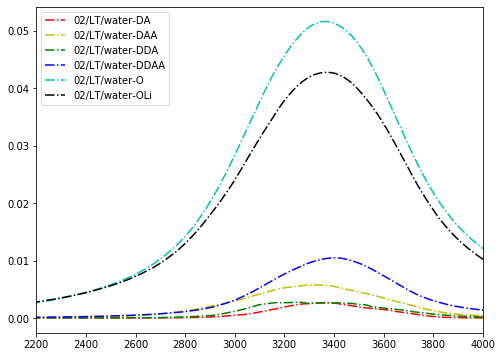

In [17]:
%matplotlib inline
res = [[],[],[],[],[],[]]
res_ang = [[],[],[],[],[],[]]
w_length_plot = np.linspace(1200,5000,1000)
colors = ['r','y','g','b','c','black']
marker = ['-.','--']
fig = plt.figure(figsize=(8,6))
for sys_id in range(2,3):
    for t, e in enumerate(['LT']):#,'RT']):
        data_all = np.zeros(w_length_plot.shape)
        for c, water in enumerate(['water-DA','water-DAA','water-DDA','water-DDAA','water-O','water-x']):
            print('0'+str(sys_id)+'/'+e+'/'+water)
            '''
            x, ang_x = temp_get_data(sys_ind = str(sys_id),Tem = e ,temp_tag='_01',water_form = water,w_length_plot = w_length_plot)
            plt.plot(w_length_plot,x,label= e+'/'+water, color=colors[c],linestyle=marker[t])
            temp = np.zeros((3,len(w_length_plot)))
            temp[0] = np.array(w_length_plot)
            temp[1] = np.array(x)
            temp[2] = np.array(ang_x)
            data_all+=x
            np.save('LiCl-vib'+'/'+str(sys_id)+'/'+e+'/'+water+'_x-bond-ang.npy',temp)
            '''
            data = np.load('LiCl-vib'+'/'+str(sys_id)+'/'+e+'/'+water+'_x-bond-ang.npy')
            #data[1] = data[1]/max(data[1])*(1+0.1*c)
            plt.plot(data[0],data[1],label='0'+str(sys_id)+'/'+e+'/'+water, color=colors[c],linestyle=marker[t])
            data_all+=data[1]
            #res[sys_id].append(x)
            #res_ang[sys_id].append(ang_x)
            
        #plt.plot(w_length_plot,data_all,label = e)
    plt.legend()
    plt.xlim(2200,4000)
    plt.show()

1

In [ ]:
def _modify(data_x, data_y):
    c_idx = np.where(data_y == max(data_y))
    overall_x = np.linspace(2500,4500,2001)
    new_x = ((data_x-data_x[c_idx])/3)+data_x[c_idx]
    new_y = np.zeros(overall_x.shape)
    for i, (x, y) in  enumerate(zip(new_x//1, data_y)):
        idx = int(x-2500)
        new_y[idx:] = np.ones((new_y[idx:]).shape)*y
    return overall_x, new_y

In [ ]:
e = 'RT'
waters = ['water-DA','water-DAA','water-DDA','water-DDAA']
for water in waters:
    data = np.load('LiCl-vib'+'/'+str(2)+'/'+e+'/'+water+'_x-bond-ang.npy')
    x, y = _modify(data[0], data[1])
    plt.plot(x,y,label = e+'_'+water)
plt.legend()
plt.xlim(2200,4000)

In [ ]:
e = 'LT'
waters = ['water-DA','water-DAA','water-DDA','water-DDAA']
all_y = np.zeros(data[0].shape)
all_y_modified = np.zeros(x.shape)
for water in waters:
    data = np.load('LiCl-vib'+'/'+str(2)+'/'+e+'/'+water+'_x-bond-ang.npy')
    np.savetxt('LiCl-vib'+'_'+e+'_'+water+'_x-bond.csv', np.concatenate(([data[0]],[data[1]])).T, delimiter=",")
    x, y = _modify(data[0], data[1])
    np.savetxt('LiCl-vib'+'_'+e+'_'+water+'_x-bond-modified.csv', np.concatenate(([x], [y])).T, delimiter=",")
    all_y+=data[1]
    all_y_modified+=y
    plt.plot(x,y,label = e+'_'+water)
plt.legend()
plt.xlim(2200,4000)

In [ ]:
np.savetxt('LiCl-vib'+'_'+e+'_'+'All'+'_x-bond.csv', np.concatenate(([data[0]],[all_y])).T, delimiter=",")
x, y = _modify(data[0], data[1])
np.savetxt('LiCl-vib'+'_'+e+'_'+'All'+'_x-bond-modified.csv', np.concatenate(([x], [all_y_modified])).T, delimiter=",")
    

In [ ]:
waters = ['water-DA','water-DAA','water-DDA','water-DDAA']
rates = []
'''
DDAA -> 3400 3450
DA -> 3400 3280 
DAA 3450 3050
DDA 3370 3550
'''
e = ['LT']
fig = plt.figure(figsize=(8,6))
overall_x = np.linspace(2500,4500,2001)
overall_y = np.zeros(overall_x.shape)

data = np.load('LiCl-vib'+'/'+str(1)+'/'+e[0]+'/'+waters[0]+'_x-bond-ang.npy')
new_x = ((data[0]-3400)/3)+3350
new_y = np.zeros(overall_x.shape)
for i, (x, y) in  enumerate(zip(new_x//1, data[1])):
    idx = int(x-2500)
    new_y[idx:] = np.ones((new_y[idx:]).shape)*y
overall_y+=new_y
plt.plot(overall_x,new_y,label='0'+str(1)+'/'+e[0]+'/'+waters[0], color=colors[0],linestyle=marker[t])
np.savetxt('LiCl-vib'+'_'+e[0]+'_'+waters[0]+'_x-bond.csv', np.concatenate(([overall_x],[new_y])).T, delimiter=",")

data = np.load('LiCl-vib'+'/'+str(1)+'/'+e[0]+'/'+waters[1]+'_x-bond-ang.npy')
new_x = ((data[0]-3400)/3)+3580

new_y = np.zeros(overall_x.shape)
for i, (x, y) in  enumerate(zip(new_x//1, data[1])):
    idx = int(x-2500)
    new_y[idx:] = np.ones((new_y[idx:]).shape)*y
overall_y+=new_y/5
plt.plot(overall_x,new_y/5,label='0'+str(1)+'/'+e[0]+'/'+waters[1], color=colors[1],linestyle=marker[t])
np.savetxt('LiCl-vib'+'_'+e[0]+'_'+waters[1]+'_x-bond.csv', np.concatenate(([overall_x],[new_y/5])).T, delimiter=",")


data = np.load('LiCl-vib'+'/'+str(1)+'/'+e[0]+'/'+waters[2]+'_x-bond-ang.npy')
new_x = ((data[0]-3450)/3)+3050

new_y = np.zeros(overall_x.shape)
for i, (x, y) in  enumerate(zip(new_x//1, data[1])):
    idx = int(x-2500)
    new_y[idx:] = np.ones((new_y[idx:]).shape)*y
overall_y+=new_y/5
plt.plot(overall_x,new_y/5,label='0'+str(1)+'/'+e[0]+'/'+waters[2], color=colors[2],linestyle=marker[t])
np.savetxt('LiCl-vib'+'_'+e[0]+'_'+waters[2]+'_x-bond.csv', np.concatenate(([overall_x],[new_y/5])).T, delimiter=",")



data = np.load('LiCl-vib'+'/'+str(1)+'/'+e[0]+'/'+waters[3]+'_x-bond-ang.npy')
new_x = ((data[0]-3370)/3)+3450

new_y = np.zeros(overall_x.shape)
for i, (x, y) in  enumerate(zip(new_x//1, data[1])):
    idx = int(x-2500)
    new_y[idx:] = np.ones((new_y[idx:]).shape)*y
overall_y+=new_y
plt.plot(overall_x,new_y,label='0'+str(1)+'/'+e[0]+'/'+waters[3], color=colors[3],linestyle=marker[t])
np.savetxt('LiCl-vib'+'_'+e[0]+'_'+waters[3]+'_x-bond.csv', np.concatenate(([overall_x],[new_y])).T, delimiter=",")

plt.plot(overall_x,overall_y,label='0'+str(1)+'/'+e[0], color=colors[4])
np.savetxt('LiCl-vib'+'_'+e[0]+'_overall_x-bond.csv', np.concatenate(([overall_x],[overall_y])).T, delimiter=",")




plt.legend()
plt.show()

In [ ]:
np.savetxt("foo.csv", np.concatenate(([overall_x],[overall_y])).T, delimiter=",")

In [ ]:
np.concatenate(([overall_x],[overall_y]))

In [ ]:
waters = ['water-DA','water-DAA','water-DDA','water-DDAA']
rates = []
'''
DDAA -> 3400 3450
DA -> 3400 3280 
DAA 3450 3050
DDA 3370 3550
'''
e = ['RT']

fig = plt.figure(figsize=(8,6))
overall_x = np.linspace(2500,4500,2001)
overall_y = np.zeros(overall_x.shape)

data = np.load('LiCl-vib'+'/'+str(1)+'/'+e[0]+'/'+waters[0]+'_x-bond-ang.npy')
new_x = ((data[0]-3400)/3)+3350
new_y = np.zeros(overall_x.shape)
for i, (x, y) in  enumerate(zip(new_x//1, data[1])):
    idx = int(x-2500)
    new_y[idx:] = np.ones((new_y[idx:]).shape)*y
overall_y+=new_y
plt.plot(overall_x,new_y,label='0'+str(1)+'/'+e[0]+'/'+waters[0], color=colors[0],linestyle=marker[t])
    

data = np.load('LiCl-vib'+'/'+str(1)+'/'+e[0]+'/'+waters[1]+'_x-bond-ang.npy')
new_x = ((data[0]-3400)/3)+3580

new_y = np.zeros(overall_x.shape)
for i, (x, y) in  enumerate(zip(new_x//1, data[1])):
    idx = int(x-2500)
    new_y[idx:] = np.ones((new_y[idx:]).shape)*y
overall_y+=new_y/5
plt.plot(overall_x,new_y/5,label='0'+str(1)+'/'+e[0]+'/'+waters[0], color=colors[1],linestyle=marker[t])


data = np.load('LiCl-vib'+'/'+str(1)+'/'+e[0]+'/'+waters[2]+'_x-bond-ang.npy')
new_x = ((data[0]-3450)/3)+3050

new_y = np.zeros(overall_x.shape)
for i, (x, y) in  enumerate(zip(new_x//1, data[1])):
    idx = int(x-2500)
    new_y[idx:] = np.ones((new_y[idx:]).shape)*y
overall_y+=new_y/5
plt.plot(overall_x,new_y/5,label='0'+str(1)+'/'+e[0]+'/'+waters[0], color=colors[2],linestyle=marker[t])



data = np.load('LiCl-vib'+'/'+str(1)+'/'+e[0]+'/'+waters[3]+'_x-bond-ang.npy')
new_x = ((data[0]-3370)/3)+3450

new_y = np.zeros(overall_x.shape)
for i, (x, y) in  enumerate(zip(new_x//1, data[1])):
    idx = int(x-2500)
    new_y[idx:] = np.ones((new_y[idx:]).shape)*y
overall_y+=new_y
plt.plot(overall_x,new_y,label='0'+str(1)+'/'+e[0]+'/'+waters[0], color=colors[3],linestyle=marker[t])

plt.plot(overall_x,overall_y,label='0'+str(1)+'/'+e[0], color=colors[4])



plt.legend()
plt.show()

In [ ]:
res_LT = res[0][:4]
res_RT = res[0][4:]
res_ang_LT = res_ang[0][:4]
res_ang_RT = res_ang[0][4:]

In [ ]:
for e in res_LT:
    plt.plot(w_length_plot,e)
plt.show()

In [ ]:
for e in res_RT:
    plt.plot(w_length_plot,e)
plt.show()

In [ ]:
fig,_ = plt.subplots(2, 2, figsize = (15, 12))

ax1 = plt.subplot(221)
ax1.plot(w_length_plot,res_LT[0],label = 'LT')
ax1.plot(w_length_plot,res_RT[0],label = 'RT')
ax1.set_title('water-DA')
ax2 = plt.subplot(222)
ax2.plot(w_length_plot,res_LT[1],label = 'LT')
ax2.plot(w_length_plot,res_RT[1],label = 'RT')
ax2.set_title('water-DAA')
ax3 = plt.subplot(223)
ax3.plot(w_length_plot,res_LT[2],label = 'LT')
ax3.plot(w_length_plot,res_RT[2],label = 'RT')
ax3.set_title('water-DDA')
ax4 = plt.subplot(224)
ax4.plot(w_length_plot,res_LT[3],label = 'LT')
ax4.plot(w_length_plot,res_RT[3],label = 'RT')
ax4.set_title('water-DDAA')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

In [ ]:
fig,_ = plt.subplots(2, 2, figsize = (15, 12))

ax1 = plt.subplot(221)
ax1.plot(w_length_plot,res_ang_LT[0],label = 'LT')
ax1.plot(w_length_plot,res_ang_RT[0],label = 'RT')
ax1.set_title('water-DA')
ax2 = plt.subplot(222)
ax2.plot(w_length_plot,res_ang_LT[1],label = 'LT')
ax2.plot(w_length_plot,res_ang_RT[1],label = 'RT')
ax2.set_title('water-DAA')
ax3 = plt.subplot(223)
ax3.plot(w_length_plot,res_ang_LT[2],label = 'LT')
ax3.plot(w_length_plot,res_ang_RT[2],label = 'RT')
ax3.set_title('water-DDA')
ax4 = plt.subplot(224)
ax4.plot(w_length_plot,res_ang_LT[3],label = 'LT')
ax4.plot(w_length_plot,res_ang_RT[3],label = 'RT')
ax4.set_title('water-DDAA')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

In [ ]:
w_length_plot = np.linspace(1500,4500,500)
x, ang_x = temp_get_data(sys_ind = '0'+str(1),Tem = 'RT' ,temp_tag='_02',water_form = 'hydronium-AAA')
plt.plot(w_length_plot,x,label='0'+str(1)+'/'+'RT'+'/'+'hydronium-AAA')
x, ang_x = temp_get_data(sys_ind = '0'+str(1),Tem = 'LT' ,temp_tag='_02',water_form = 'hydronium-AAA')
plt.plot(w_length_plot,x,label='0'+str(1)+'/'+'LT'+'/'+'hydronium-AAA')
plt.show()

In [ ]:
res = [[],[],[],[],[],[]]
res_ang = [[],[],[],[],[],[]]
for sys_id in range(0,1):
    for e in ['LT','RT']:
        for water in ['water-DA','water-DAA','water-DDA','water-DDAA']:
            print('0'+str(sys_id)+'/'+e+'/'+water)
            x, ang_x = temp_get_data(sys_ind = '0'+str(sys_id),Tem = e ,temp_tag='_02',water_form = water)
            plt.plot(w_length_plot,x,label='0'+str(sys_id)+'/'+e+'/'+water)
            res[sys_id].append(x)
            res_ang[sys_id].append(ang_x)
plt.legend()
plt.show()

In [ ]:
import subprocess

data_path = '/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/RT/2case/lammps/'
filename = 'log.lammps'
with open(os.path.join(data_path,filename),'r') as f:
    lines = f.readlines()
#lines = [e.split() for e in lines if len(e.split())==9]

In [ ]:
lines = [e.split() for e in lines if len(e.split())==9]

In [ ]:
lines = [[float(e) for e in line] for line in lines if line[0].isnumeric()]

In [ ]:
lines = np.array(lines)

In [ ]:
plt.plot(lines[:,0],lines[:,1])

In [ ]:
temp = [sum(lines[i-10:i,1])/10 for i in range(10, len(lines))]

In [ ]:
plt.plot(temp[50:]) 
#50*

In [ ]:
plt.plot(lines[40:,0],lines[40:,1])
plt.title('case1')

In [ ]:
plt.plot(lines[1:,0],lines[1:,1])
'case2-LT'

In [ ]:
plt.plot(lines[1:,0],lines[1:,1])
'case2-RT'

In [ ]:
plt.plot(lines[150000:,0],lines[150000:,1])

In [ ]:
def O_Odis(Tem = 'RT',sys_ind = '1',temp_tag='_01'):

    data_path = '/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/'+Tem+'/'+sys_ind+'case/dft'
    filename = 'CONTCAR'
    ###
    #Reading File
    ###

    with open(os.path.join(data_path,filename),'r') as f:
        lines = f.readlines()
    box = lines[2:5]
    box =[e.split() for e in box]
    box = [box[0][0],box[1][1],box[2][2]]
    box = [float(e) for e in box]
    lines = lines[5:]
    types = lines[0].split()
    temp = lines[1].split()
    temp = [int(e) for e in temp]
    eles = []
    atom_num = sum(temp)

    for _i,_j in zip(types, temp):
        eles = eles+[[_i]]*_j
    eles = np.array(eles, dtype = 'object')
    lines = lines[2:]
    
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:1+atom_num]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)

    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]

    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    
    O_pos = atoms[Oinds,1:]
    
    res = []
    for i, e in enumerate(O_pos): 
        #print(np.concatenate((O_pos[:i],O_pos[i+1:])))
        temp = distance(box, e, np.concatenate((O_pos[:i],O_pos[i+1:])))
        res = np.concatenate((res,temp))
    return res

In [ ]:
x1,x2 = O_Odis(Tem = 'RT',sys_ind = '3'),O_Odis(Tem = 'LT',sys_ind = '3',temp_tag='_01')
plt.hist([x1,x2],bins=10,label=['RT','LT'])
plt.legend(loc='upper left')
plt.show()

In [ ]:
x1,x2 = O_Odis(Tem = 'RT',sys_ind = '1'),O_Odis(Tem = 'LT',sys_ind = '1',temp_tag='_01')
plt.hist([x1,x2],bins=10,label=['RT','LT'])
plt.legend(loc='upper left')
plt.show()

number of water mole

In [ ]:
tem = 'RT'
data_path = '/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/'+tem+'/'+'2'+'case/dft'
filename = 'CONTCAR'
with open(data_path+'/'+filename, 'r') as f:
    lines = f.readlines()
lines[5:7],lines[8:]

In [ ]:
lines[5:7]
lines[5] = '   Li   Cl   O1   O2   O3   O4   O5    H \n'
lines[6] = '    13    13    20    22    13    16    21   184\n'

In [ ]:
Counter(x[-1])

In [ ]:
x = np.load('LiCl/'+str(2)+'/'+tem+"_O_form"+'_01'+".npy")
np.where(x[-1] == 3)

In [ ]:
o_lines
new_olines = []
x = np.load('LiCl/'+str(2)+'/'+tem+"_O_form"+'_01'+".npy")
for i in range(6):
    i_s = np.where(x[-1] == i)[0]
    for _i in i_s:
        new_olines.append(o_lines[_i])
new_olines, len(new_olines)

In [ ]:
lines[8+26:8+26+92] = new_olines[:]

In [ ]:
lines
with open(filename+'_org_'+tem, 'w+') as f:
    f.writelines(lines)

In [ ]:
#{'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
#                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}

In [ ]:
def LiCl_pair(tem = 'RT'):
    data_path = '/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/'+tem+'/'+'2'+'case/dft'
    filename = 'XDATCAR'
    with open(data_path+'/'+filename, 'r') as f:
        lines = f.readlines()
    box = [max([float(_e) for _e in e.split()]) for e in lines[2:5]]
    def one_step(_lines, box):
        atoms_Li = [[float(_e)*box[i] for i, _e in enumerate(e.split())] for e in _lines[1:1+13]]
        atoms_Cl = [[float(_e)*box[i] for i, _e in enumerate(e.split())] for e in _lines[14:14+13]]

        count = 0
        for atom_Li in atoms_Li:
            if min(distance(box, atom_Li, atoms_Cl)) < 2.5:
                count+=1
        return count
    lines = lines[7+100*303:7+250*303]
    steps_n = 0
    tot_pair = 0
    while len(lines)>=303:
        steps_n+=1
        tot_pair+=one_step(lines, box)
        lines = lines[303:]
    return tot_pair/steps_n

# TEST DATA - Hbond Parameters

In [16]:
def water_form_count(lines, eles, box):  # , res_type = 'idxs'):
    #mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
    #                    'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)
    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]
        
    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    Linds = np.where(atoms[:,0]=='Li')[0]
    Cinds = np.where(atoms[:,0]=='Cl')[0]

    Os = atoms[Oinds,1:]
    Hs = atoms[Hinds,1:]
    Ls = atoms[Linds,1:]
    Cs = atoms[Cinds,1:]

    
    '''
    pair_coeff 1 1 0.07647 2.126 # Li
    pair_coeff 2 2 0.4928 4.417 # Cl
    pair_coeff 3 3 0.1553 3.166      # O
    pair_coeff 4 4 0.0460    0.4000      # H
    pair_coeff 3 4 0.0    0.0 #OH
    
    '''
    OH_cutoff = 1.28
    O_H_cutoff = 2.25     # O...H < 2.25 
    O_Li_cutoff = 2.33  
    H_Cl_cutoff = 2.441  
    OO_cutoff = 3.4       # O-O < 3.4 A   
    
    # H_Cl
    # https://pubs.acs.org/doi/10.1021/jp310596c
    # H-Cl: 2.441        O-H...Cl 119.0
        
    mol = []
    OO_mat = np.zeros(( len(Os) , len(Os) ))
    HinWater = np.zeros(( len(Os) , 2 , 3 ))
    


    for i in range(len(Os)):
        temp = distance(box, Os[i], Os)
        for _i in np.where(temp<=OO_cutoff)[0]:
            if i == _i:
                continue
            OO_mat[i,_i] = 1
        HinWater[i] = Hs[findNearest(box, Os[i], Hs, 2)]
    for i in range(len(Os)):
        
        ## A
        pot_Os = Os[np.where(OO_mat[i]==1)[0]]
        
        pot_Hs = np.concatenate(HinWater[np.where(OO_mat[i]==1)[0]])
        temp_OH = distance(box, Os[i], pot_Hs)
        No_O_H = len(np.where(temp_OH<O_H_cutoff)[0])
        
        t = []
        t.append(No_O_H)
        
        
        ## D
        doner_H = 0
        #print(i)
        for _H in HinWater[i]:
            temp_HO = distance(box, _H, pot_Os)
            #print(sorted(temp_HO))
            temp_HO = np.where(temp_HO<O_H_cutoff)[0]
            doner_H += (len(temp_HO))
        t.append(doner_H)
        
        ## A-Li
        temp_OL = distance(box, Os[i], Ls)
        OL_idx = np.where(temp_OL<O_Li_cutoff)[0]
        No_OL = len(OL_idx)
        t.append(No_OL)
        
        
        ## D-Cl
        doner_H = 0
        #print(i)
        for _H in HinWater[i]:
            temp_HC = distance(box, _H, Cs)
            #print(sorted(temp_HO))
            temp_HC = np.where(temp_HC<H_Cl_cutoff)[0]
            doner_H += (len(temp_HC)-1)
        #print(doner_H)
        t.append(doner_H)
        
        mol.append(t)
        
    mol = np.array(mol,dtype='object')
    
    mol_type = ['']*len(Os)
    for i, wat in enumerate(mol):
        temp = ''
        temp = temp+'C'*wat[3]
        temp = temp+'D'*wat[1]
        temp = temp+'A'*wat[0]
        temp = temp+'L'*wat[2]
        mol_type[i] = temp
        '''
        if res_type == 'idxs':
            if temp not in mol_type_class:
                mol_type[i] = 5
            else:
                mol_type[i] = mol_type_class[temp]
        else:
            mol_type[i] = temp
        '''
    return mol_type

In [ ]:
def water_form_lifetime(mol_type_time, water_form_idx = -1, water_form = 'water-DDAA'):
    
    mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    if water_form_idx == -1:
        form_idx = mol_type_class[water_form]
    else:
        form_idx = water_form_idx
    periods = []
    periods_statis = []
    for i in range(len(mol_type_time[0])):
        l = mol_type_time[:,i]
        _start=0
        _end = 0
        _if = 0
        _periods = []
        for _i, e in enumerate(l):
            if e == form_idx:
                if _if == 0:
                    _start = _i
                    _if=1
                if _if == 1:
                    _end = _i
            if e != form_idx:
                if _if == 1:
                    _period = _end - _start
                    _if=0
                    if _period > 50:
                        _periods.append([_start,_end])
                        periods_statis.append(_end - _start)
            #print(_start,_end,_if,e)
        if _if == 1:
            _period = _end - _start
            if _period > 50:
                _periods.append([_start,_end])
                periods_statis.append(_end - _start)
        #print(i,_periods)
        periods.append(_periods)
    return periods, periods_statis


Pdf O-Li
Distribution of O-Li distance

In [17]:
def water_form_count_all(Tem = 'RT',sys_ind = '2',temp_tag='_pset_01'):

    data_path = '/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/'+Tem+'/'+sys_ind+'case/dft/'
    filename = 'XDATCAR'
    #filename = 'XDATCAR01'
    
    
    ###
    #Reading File
    ###

    with open(os.path.join(data_path,filename),'r') as f:
        lines = f.readlines()
    box = lines[2:5]
    box =[e.split() for e in box]
    box = [box[0][0],box[1][1],box[2][2]]
    box = [float(e) for e in box]
    lines = lines[5:]
    types = lines[0].split()
    temp = lines[1].split()
    temp = [int(e) for e in temp]
    eles = []
    atom_num = sum(temp)

    for _i,_j in zip(types, temp):
        eles = eles+[[_i]]*_j
    eles = np.array(eles, dtype = 'object')
    lines = lines[2:]
    
    
    ###
    #Generating lifetime info
    ###   
    
    print('generating formation lifetime info....')
    
    ######
    res = []
    ###
    
    mol_type_time = np.array(np.zeros((int(len(lines)/(atom_num+1)), len(np.where(eles=='O')[0]))),dtype='str')
    for i in range(0,int(len(lines)/(atom_num+1)) ):
        temp = water_form_count(lines[i*(atom_num+1):(i+1)*(atom_num+1)], eles, box)
        mol_type_time[i] = temp

        if i%500 == 0:
            print(i)
    return mol_type_time
    
    

In [ ]:
def temp_get_data(sys_ind = '1',Tem = 'RT',temp_tag='_02',water_form = 'water-DDAA',w_length_plot = np.linspace(2500,4500,300)):



In [ ]:
_x = water_form_count_all()

In [ ]:
_x = np.concatenate(np.array(_x))
_x = np.concatenate(np.array(_x))
_x.shape

In [ ]:
test_data = _x#water_form_count_all()

In [ ]:
temp_data = test_data[-20]

In [ ]:
test_data

In [ ]:
temp_data = np.concatenate(test_data)

In [ ]:
np.where(test_data[-1]!=test_data[-20])

In [ ]:
from collections import Counter
show_data = Counter(temp_data)
del show_data['0.0']

In [ ]:
show_data

In [ ]:
_total = 460000 # sum(show_data.values())
for _e in show_data:
    show_data[_e] = show_data[_e]/_total * 100
'''
    DA     DAA    DDA     DDAA
L 13.520000000000007,23.13000000000001,12.109999999999998,25.129999999999978
R 17.439999999999994,22.46000000000001,14.080000000000028,15.840000000000003
'''    
    
show_data

In [ ]:
def water_form_lifetime(mol_type_time, water_form_idx = -1, water_form = 'water-DDAA'):
    
    mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    if water_form_idx == -1:
        form_idx = mol_type_class[water_form]
    else:
        form_idx = water_form_idx
    periods = []
    periods_statis = []
    for i in range(len(mol_type_time[0])):
        l = mol_type_time[:,i]
        _start=0
        _end = 0
        _if = 0
        _periods = []
        for _i, e in enumerate(l):
            if e == form_idx:
                if _if == 0:
                    _start = _i
                    _if=1
                if _if == 1:
                    _end = _i
            if e != form_idx:
                if _if == 1:
                    _period = _end - _start
                    _if=0
                    if _period > 50:
                        _periods.append([_start,_end])
                        periods_statis.append(_end - _start)
            #print(_start,_end,_if,e)
        if _if == 1:
            _period = _end - _start
            if _period > 50:
                _periods.append([_start,_end])
                periods_statis.append(_end - _start)
        #print(i,_periods)
        periods.append(_periods)
    return periods, periods_statis